The following is implementation of [depth map prediction from a single image using multi-scale deep network](https://arxiv.org/abs/1406.2283). NYUdataset is used for training, validation and testing phase. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Importing necessary libraries

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import h5py
import numpy as np
import torch.nn as nn 
import torch
import os
import cv2
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
os.chdir('/content/drive/My Drive/ColabNotebooks/imran_depth_single_multi_network')
from data import NYUDataset, rgb_data_transforms, depth_data_transforms

## Preparing Dataset

### utily functions

In [0]:
def PSNR(y_true, y_pred):
    max_val = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_val)

def image_preprocess(img):
  img = img.transpose((2, 1, 0))
  img = cv2.resize(img, (304, 228))
  return img

def depth_preprocessing(depth):
  depth = np.reshape(depth, (1, depth.shape[0], depth.shape[1]))
  depth = depth.transpose((2, 1, 0))
  depth = depth.transpose((2, 0, 1))
  depth = torch.from_numpy(depth)
  depth = depth.view(1, depth.shape[0], depth.shape[1], depth.shape[2])
  depth = nn.functional.interpolate(depth, size = (55, 74), mode='bilinear', align_corners=False)
  return np.array(depth[0][0])

### Downloading Dataset 

In [0]:
!wget http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat

### One pair training image and depth map from dataset 

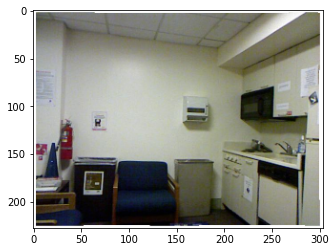

(228, 304, 3)
<class 'numpy.ndarray'>


In [4]:
f = h5py.File('nyu_depth_v2_labeled.mat', 'r')
plt.imshow(image_preprocess(f['images'][0]))
plt.show()
print(image_preprocess(f['images'][0]).shape)
print(type(image_preprocess(f['images'][0])))

(55, 74)
<class 'numpy.ndarray'>


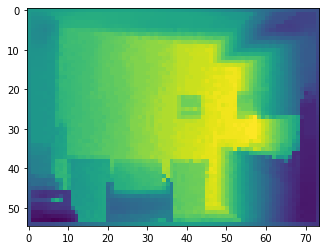

In [5]:
print(depth_preprocessing(f['depths'][0]).shape)
print(type(depth_preprocessing(f['depths'][0])))
plt.imshow(depth_preprocessing(f['depths'][0]))
plt.show()

### Defining Training, validation and testing dataset

In [0]:
f = h5py.File('nyu_depth_v2_labeled.mat', 'r')
image_data = [image_preprocess(i) for i in f['images'][0:1449]]
depth_data = [depth_preprocessing(i) for i in f['depths'][0:1449]]


training_depth_data = np.array(depth_data[0:1024])
training_image_data = np.array(image_data[0:1024])

val_image_data = np.array(image_data[1024:1248])
val_depth_data = np.array(depth_data[1024:1248])

test_image_data = np.array(image_data[1248:])
test_depth_data = np.array(depth_data[1248:])

print(type(training_depth_data))
print(type(training_image_data))
print(training_depth_data.shape)
print(training_image_data.shape)

Total 1449 images are there with size of 640*480 in RGB format

## Coarse Model

In [0]:
def make_coarse_model():
  model = tf.keras.Sequential()
  # 1
  model.add(layers.Conv2D(96, (11, 11), input_shape=(image_data[0].shape[0], image_data[0].shape[1], 3), strides=4 , padding='valid'))
  model.add(layers.LeakyReLU())
  model.add(layers.MaxPooling2D())
  # 2
  model.add(layers.Conv2D(256, (5,5), padding='valid'))
  model.add(layers.LeakyReLU())
  model.add(layers.MaxPooling2D())
  # 3 
  model.add(layers.Conv2D(384, (3, 3), padding='valid'))
  model.add(layers.LeakyReLU())
  # 4
  model.add(layers.Conv2D(384, (3, 3), padding='valid'))
  model.add(layers.LeakyReLU())
  # 5
  model.add(layers.Conv2D(256, (3, 3), padding='valid'))
  model.add(layers.LeakyReLU())
  model.add(layers.Flatten())
  model.add(layers.Dense(4096))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4070))
  model.add(layers.Reshape((55, 74)))
  adam = tf.keras.optimizers.Adam(3e-4)

  model.compile(optimizer=adam,
                loss='mse',
                metrics=['mean_squared_error', PSNR])
  
  return model


Model initialization

In [0]:
BATCH_SIZE = 16
EPOCHS = 10
coarse_model = make_coarse_model()
coarse_model.summary()

Training coarse model

In [0]:
def train_coarse(model, EPOCHS, BATCH_SIZE):

    # Make checkpoints
    checkpoint = tf.keras.callbacks.ModelCheckpoint("Depth_checkpoint.h5",
                    monitor='val_loss', verbose=1, save_best_only=True,
                    save_weights_only=False, mode='min')
    callbacks_list = [checkpoint]

    history = model.fit(training_image_data, training_depth_data, batch_size=BATCH_SIZE,
                        validation_data=(val_image_data, val_depth_data),
                        callbacks=callbacks_list,
                        shuffle=True,
                        epochs=EPOCHS)

    return history

In [0]:
coarse_history = train_coarse(coarse_model, EPOCHS, BATCH_SIZE)
np.save('coarse_history', coarse_history)

## Fine Model

Fine-Model Definition

In [0]:
def make_fine_model():
  image_input = tf.keras.Input(shape=(image_data[0].shape[0], image_data[0].shape[1], 3), name = 'img_ip')
  depth_input = tf.keras.Input(shape=(depth_data[0].shape[0], depth_data[0].shape[1], 1), name='depth_ip')
  x1 = layers.Conv2D(63, 9, strides = (2, 2))(image_input)
  x1 = layers.LeakyReLU(0.3)(x1)
  x1 = layers.MaxPool2D(pool_size=(2, 2))(x1)
  x2 = layers.concatenate((x1, depth_input))
  x2 = layers.Conv2D(64, 5, padding = 'same')(x2)
  x2 = layers.LeakyReLU(0.3)(x2)
  output = layers.Conv2D(1, 5, padding = 'same', name='output')(x2)
  model = keras.Model(inputs = [image_input, depth_input], outputs = [output])
  adam = tf.keras.optimizers.Adam(3e-4)
  model.compile(optimizer=adam,
                loss='mse',
                metrics=['mean_squared_error', PSNR])
  
  return model

Training Fine-Model

In [0]:
def train_fine(model, EPOCHS, BATCH_SIZE):
  # loading weights of coarse model
  coarse_model.load_weights('Depth_checkpoint.h5')

  # Predicting depth for training image from coarse model which will be used for fine model
  training_coarse_depth = coarse_model.predict(training_image_data)
  training_coarse_depth = np.expand_dims(training_coarse_depth, axis=3)

  # predicting depth for training image
  val_coarse_depth = coarse_model.predict(val_image_data)
  val_coarse_depth = np.expand_dims(val_coarse_depth, axis=3)
  
  # Make checkpoints
  checkpoint = tf.keras.callbacks.ModelCheckpoint("Depth_checkpoint_fine.h5",
                  monitor='val_loss', verbose=1, save_best_only=True,
                  save_weights_only=False, mode='min')
  callbacks_list = [checkpoint]

  history = model.fit({'img_ip' : training_image_data, 'depth_ip': training_coarse_depth}, {'output': training_depth_data}, batch_size=BATCH_SIZE,
                      validation_data=({'img_ip' : val_image_data, 'depth_ip': val_coarse_depth}, {'output': val_depth_data}),
                      callbacks=callbacks_list,
                      shuffle=True,
                      epochs=EPOCHS)

  return history

In [0]:
BATCH_SIZE = 16
EPOCHS = 10
fine_model = make_fine_model()
fine_model.summary()

In [0]:
history_2 = train_fine(fine_model, EPOCHS, BATCH_SIZE)

## Display Output image & Ground Truth

Function for displaying output image

In [0]:
def plot_grid(fig, plot_input, coarse_output, fine_output, actual_output, row_no):
  for i in range(row_no):
    for j in range(4):
      if(j == 0):
        fig[i, j].imshow(plot_input[i], interpolation="nearest")
      if(j == 1):
        fig[i, j].imshow(coarse_output[i], interpolation="nearest")
      if(j == 2):
        fig[i, j].imshow(fine_output[i], interpolation="nearest")
      if(j == 3):
        fig[i, j].imshow(actual_output[i], interpolation="nearest")
  plt.show()

Displaying Output

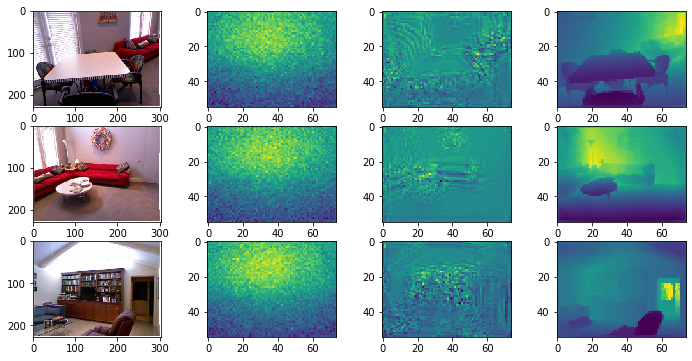

In [0]:
coarse_model.load_weights('Depth_checkpoint.h5')
predicted_coarse_depth = coarse_model.predict(test_image_data)

fine_model.load_weights('Depth_checkpoint_fine.h5')
predicted_fine_depth = fine_model.predict({'img_ip' : test_image_data, 'depth_ip': predicted_coarse_depth})
predicted_fine_depth = np.transpose(predicted_fine_depth[:], (3, 0, 1, 2))[0]

no_of_result = 3
Fig, axis = plt.subplots(no_of_result, 4, figsize = (12,6))   
plot_grid(axis, test_image_data[:no_of_result], predicted_coarse_depth[:no_of_result], predicted_fine_depth[0:no_of_result], test_depth_data[:no_of_result], no_of_result)